# **Análisis Exploratorio (EDA) del OWID Energy Consumption** 

## **Librerías y módulos necesarios**

In [624]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.tsa.api as smtsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import plotly.express as px
import pycountry
import plotly.graph_objects as go


## **Datos importantes**

Para realizar un Análisis Exploratorio de Datos (EDA) efectivo, debemos seleccionar las variables más relevantes del conjunto de datos para responder a las preguntas clave. Aquí tienes las variables más importantes que pueden ser útiles en un EDA sobre consumo energético, tomando en cuenta la estructura del conjunto de datos:

1. **`country`**: País o región. Es importante para segmentar el análisis por geografía.
2. **`year`**: Año. Fundamental para el análisis temporal de tendencias.
3. **`population`**: Población. Ayuda a entender el consumo per cápita.

Estas variables permiten un análisis profundo de las tendencias de consumo energético, su relación con factores económicos y demográficos, y su impacto en el medio ambiente.

### **Base de Datos**

In [625]:
df_full = pd.read_csv("C:/Users/ADM/Documents/MachineLearningUN/ML_ProyectoFinal/base/owid-energy-data.csv", sep=",")

### **Caracteristicas de la Base de Datos**

In [626]:
df_full.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21812 entries, 0 to 21811
Columns: 129 entries, country to wind_share_energy
dtypes: float64(126), int64(1), object(2)
memory usage: 21.5+ MB


El DataFrame resultante tiene 21,812 entradas y 129 columnas. Cada entrada probablemente representa un año para un país específico, mientras que las columnas parecen incluir diferentes variables relacionadas con el consumo y producción de energía.
Las variables contienen 126 columnas de tipo float64 (posiblemente datos numéricos continuos, como el consumo de diferentes tipos de energía), 1 columna de tipo int64 (probablemente algún tipo de identificación o año), y 2 columnas de tipo object (posiblemente nombres de países o categorías).

In [627]:
df_full.describe(include = object)


,country,iso_code
count,21812,16812
unique,294,220
top,Zimbabwe,ZWE
freq,124,124


En este paso del análisis de datos, se tomó la decisión de eliminar las filas que contienen valores faltantes (`NaN`) en las columnas clave: **`country`** (país), **`year`** (año) y **`population`** (población). Estas columnas son esenciales para el análisis, ya que cada observación debe estar asociada a un país, un año específico y su respectiva población. Sin estos valores, el análisis de tendencias temporales, de consumo por país, o de cálculos de consumo per cápita sería inconsistente o incorrecto.

La columna **`country`** es indispensable porque los datos se agrupan por países, y eliminar filas sin este dato asegura que cada registro esté correctamente identificado. Asimismo, la columna **`year`** es fundamental para garantizar que cada entrada esté asociada a un año específico, necesario para cualquier análisis de series temporales. Finalmente, la columna **`population`** es clave para cálculos per cápita o análisis de densidad poblacional en el consumo energético. Por estas razones, eliminar filas con valores faltantes en estas columnas ayuda a mantener la integridad del análisis.

In [628]:
# Eliminamos filas que tengan NaN en las columnas 'country', 'year' o 'population'
df = df_full.dropna(subset=['country', 'year', 'population'])

# Mostramos las primeras filas del DataFrame resultante
df.head(9)

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
24,Afghanistan,1900,AFG,4707744.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,Afghanistan,1901,AFG,4751177.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,Afghanistan,1902,AFG,4802500.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,Afghanistan,1903,AFG,4861833.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,Afghanistan,1904,AFG,4921891.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,Afghanistan,1905,AFG,4982681.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,Afghanistan,1906,AFG,5044212.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,Afghanistan,1907,AFG,5106495.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,Afghanistan,1908,AFG,5169536.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Una vez que se eliminaron las filas con valores `NaN` en estas tres columnas clave, se mostró el resultado utilizando `df.head()` para visualizar las primeras cinco filas del DataFrame resultante. Este paso es crucial para verificar que los datos se han procesado correctamente y que las filas que permanecen contienen la información necesaria.

In [629]:
df.shape

(18447, 129)

Aqui nos indica que el DataFrame ahora tiene 18,447 filas y 129 columnas. Esto refleja el tamaño del conjunto de datos después de eliminar las filas con valores faltantes en las columnas clave.

## **Agrupación de datos**

### **Agrupacion de Energias Renovables y no Renovables**

En este paso, se tomaron las columnas del DataFrame relacionadas con el consumo de energía y se agruparon en dos listas: **energías renovables** y **energías no renovables**. Este proceso facilita la manipulación y análisis por separado de ambos tipos de fuentes de energía, lo que es crucial cuando se desean analizar patrones de consumo específicos para cada tipo.

- **`ren_energy_columns`**: Esta lista agrupa todas las columnas relacionadas con el consumo de **energías renovables**. Las fuentes de energía incluidas aquí, como la biomasa, la energía hidroeléctrica, solar, eólica y nuclear, son aquellas consideradas como fuentes sostenibles a largo plazo. La decisión de agrupar estas columnas permite enfocarse en el análisis de tendencias y comportamientos relacionados con la transición energética hacia fuentes más limpias.

- **`nonren_energy_columns`**: Esta lista contiene las columnas relacionadas con el consumo de **energías no renovables**, como los combustibles fósiles (carbón, gas natural y petróleo). Estas fuentes son fundamentales para entender las emisiones de gases de efecto invernadero y la dependencia de los combustibles tradicionales, permitiendo así el análisis comparativo con las renovables.

In [630]:
ren_energy_columns = [
    'biofuel_consumption', 
    'hydro_consumption', 
    'solar_consumption', 
    'wind_consumption', 
    'nuclear_consumption', 
    'other_renewable_consumption',
]

nonren_energy_columns = [
    'fossil_fuel_consumption',
    'coal_consumption',
    'gas_consumption',
    'oil_consumption'
]

Agrupar estas columnas en dos categorías permite realizar un análisis más estructurado y facilita la comparación entre el consumo de fuentes renovables y no renovables. Esto es particularmente útil cuando se estudian tendencias de sostenibilidad energética, el impacto de las políticas medioambientales y el progreso hacia una matriz energética más limpia.

Esta separación también ayuda a visualizar y calcular indicadores clave, como la proporción de consumo de energía renovable frente a la no renovable a lo largo del tiempo, lo que es vital para estudios sobre el cambio climático y la eficiencia energética de los países.

### **Filtro del Conjunto de Datos**

El objetivo de este bloque de código es **filtrar el conjunto de datos** para enfocarse únicamente en los **países individuales** y excluir las **regiones, continentes y agrupaciones** de países. Esto es importante porque el análisis de consumo energético renovable se enfoca en países, y el incluir datos agregados a nivel de regiones como "World" o "Europe" podría distorsionar los resultados al mezclar datos agregados con datos por país.

La decisión de excluir regiones más amplias asegura que el análisis se centre en las comparaciones entre países específicos, lo que es más útil para identificar tendencias o realizar análisis de impacto por nación.


- Primero, se filtran los datos para el período entre **1990 y 2022**, que es el intervalo de tiempo de interés para el análisis. Esto elimina los datos de años fuera de ese rango, que probablemente no sean relevantes o no tengan datos suficientes.

- Luego, se excluyen agrupaciones geográficas o económicas más amplias como "World", "Europe", "Asia", "North America", entre otras. Estas agrupaciones suelen sumar los datos de varios países, y al excluirlas se garantiza que el análisis se enfoque exclusivamente en naciones individuales. Las agrupaciones por nivel de ingresos (como "High-income countries") también se eliminan, ya que podrían interferir con el análisis de países específicos.

- Se agrupan los datos por país y se suman los valores de todas las energías renovables seleccionadas en la variable `ren_energy_columns`. Esto permite calcular el consumo total de energías renovables para cada país.
   
- Luego, se suman estos valores para cada país y se almacena en una nueva columna llamada **`total_renewable`**, que refleja el consumo total de energías renovables por país.

In [631]:
df_filtered_range = df[(df['year'] >= 1990) & (df['year'] <= 2022)]
df_filtered_range = df_filtered_range[(df['country'] != 'World') & 
                (df_filtered_range['country'] != 'Europe') & 
                (df_filtered_range['country'] != 'Asia') & 
                (df_filtered_range['country'] != 'North America') & 
                (df_filtered_range['country'] != 'High-income countries') & 
                (df_filtered_range['country'] != 'Lower-middle-income countries') & 
                (df_filtered_range['country'] != 'Upper-middle-income countries') & 
                (df_filtered_range['country'] != 'European Union (27)') & 
                (df_filtered_range['country'] != 'South America')]

C:\Users\ADM\AppData\Local\Temp\ipykernel_4248\3088417971.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Este enfoque asegura que los **10 países más destacados** en el consumo de energías renovables se seleccionen sin distorsión, al evitar los datos agregados de regiones y continentes enteros. Además, permite realizar comparaciones claras y significativas entre los países individuales, lo que es crucial para evaluar el progreso hacia el uso de fuentes de energía más limpias a nivel nacional

## **Detección de Valores Atípicos**

En este código se decide crear un boxplot que muestra la distribución del consumo de energías renovables de los 10 países con mayor consumo de energías renovables en el periodo de 1990 a 2022. La selección de estos países permite un análisis detallado de cómo ha sido el comportamiento del consumo de energías limpias entre los países. Los 10 países seleccionados son los que más consumen energías renovables, lo que los convierte en un grupo clave para estudiar cómo ha evolucionado el uso de estas fuentes limpias.

El boxplot también es útil para detectar outliers (valores atípicos) que pueden representar eventos singulares, como políticas energéticas, cambios tecnológicos, o condiciones económicas que impulsaron o afectaron el consumo de energías renovables en esos países. Además, al agrupar por año, permite visualizar cómo ha cambiado el comportamiento global de consumo en estos países en un período de más de 30 años.

In [632]:
# Sumar energías para cada categoría
df_filtered_range['ren_energy'] = df_filtered_range[ren_energy_columns].sum(axis=1)
df_filtered_range['nonren_energy'] = df_filtered_range[nonren_energy_columns].sum(axis=1)

C:\Users\ADM\AppData\Local\Temp\ipykernel_4248\611516514.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




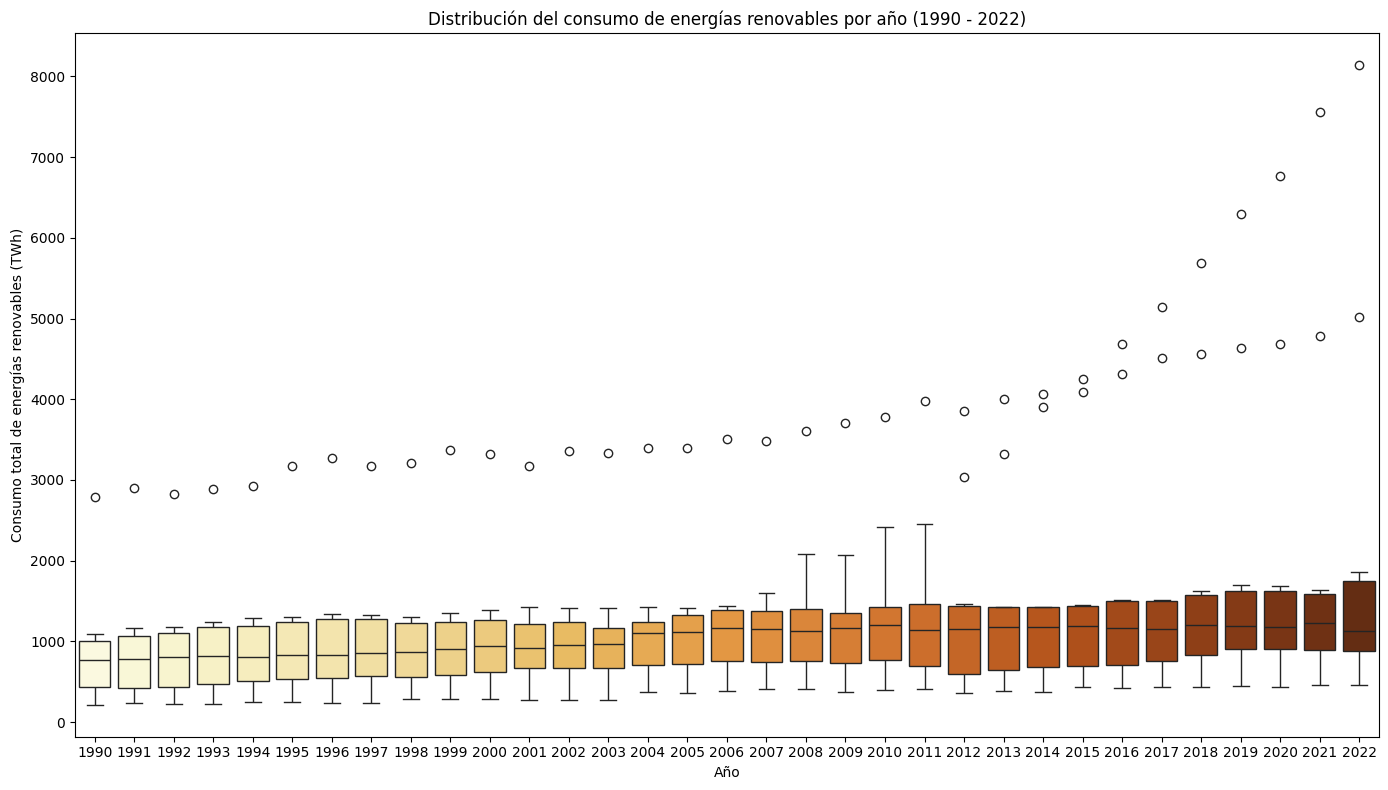

In [633]:
top10_countries = df_filtered_range.groupby('country')['ren_energy'].sum().nlargest(10).index
df_top10 = df_filtered_range[df_filtered_range['country'].isin(top10_countries)]

# Crear un boxplot por año mostrando la distribución de consumo de energías renovables por país
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_top10, x='year', y='ren_energy', palette='YlOrBr')

plt.title('Distribución del consumo de energías renovables por año (1990 - 2022)')
plt.xlabel('Año')
plt.ylabel('Consumo total de energías renovables (TWh)')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

El gráfico muestra la distribución anual del consumo de energías renovables de los 10 países con mayor consumo entre 1990 y 2022. La mediana del consumo se mantiene estable en los primeros años, alrededor de 1,000 TWh, pero muestra un ligero aumento hacia años más recientes. Esto indica un crecimiento gradual en el uso de energías renovables.

A partir de 2007, se observa un incremento en la dispersión del consumo de energía, lo que indica una mayor variabilidad entre países. Algunos países han avanzado significativamente más en su adopción de energías renovables que otros, lo que se refleja en el aumento del rango intercuartílico.

Los outliers (valores atípicos) son especialmente visibles a partir de 2010. Estos puntos representan países que han tenido un consumo de energías renovables mucho mayor que el promedio, superando los 7,000-8,000 TWh en los últimos años. Esto podría deberse a políticas energéticas agresivas o avances tecnológicos en dichos países.

### **Método de Imputación por Interpolación Lineal**

Implementa dos pasos clave para mejorar la calidad del conjunto de datos: eliminación de valores atípicos y imputación por interpolación lineal de los valores faltantes. La razón de esta decisión es asegurar que los datos sean más consistentes y que los valores atípicos no distorsionen los resultados de los análisis.

El método del rango intercuartílico (IQR) se utiliza para identificar y eliminar los valores atípicos. Los cuartiles 1 y 3 (Q1 y Q3) se utilizan para calcular el IQR, que mide la dispersión entre los datos. Se define un rango (entre el límite inferior y superior) donde se encuentran los valores normales. Todo lo que quede fuera de este rango se considera atípico y se elimina.
Se decidió eliminar los valores atípicos para asegurar que el análisis no esté influenciado por consumos extremadamente altos o bajos que puedan ser excepcionales o errores en los datos.
Interpolación por interpolación lineal para imputar valores faltantes:

Después de eliminar los outliers, se aplica la interpolación lineal para imputar los valores faltantes en las columnas de energías renovables. La interpolación lineal es una técnica que toma los valores antes y después de una posición vacía y calcula un valor intermedio para llenar ese espacio. Esto es útil porque permite mantener la continuidad temporal y evitar que los valores faltantes interrumpan los patrones o tendencias en el análisis.

C:\Users\ADM\AppData\Local\Temp\ipykernel_4248\25317863.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ADM\AppData\Local\Temp\ipykernel_4248\25317863.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




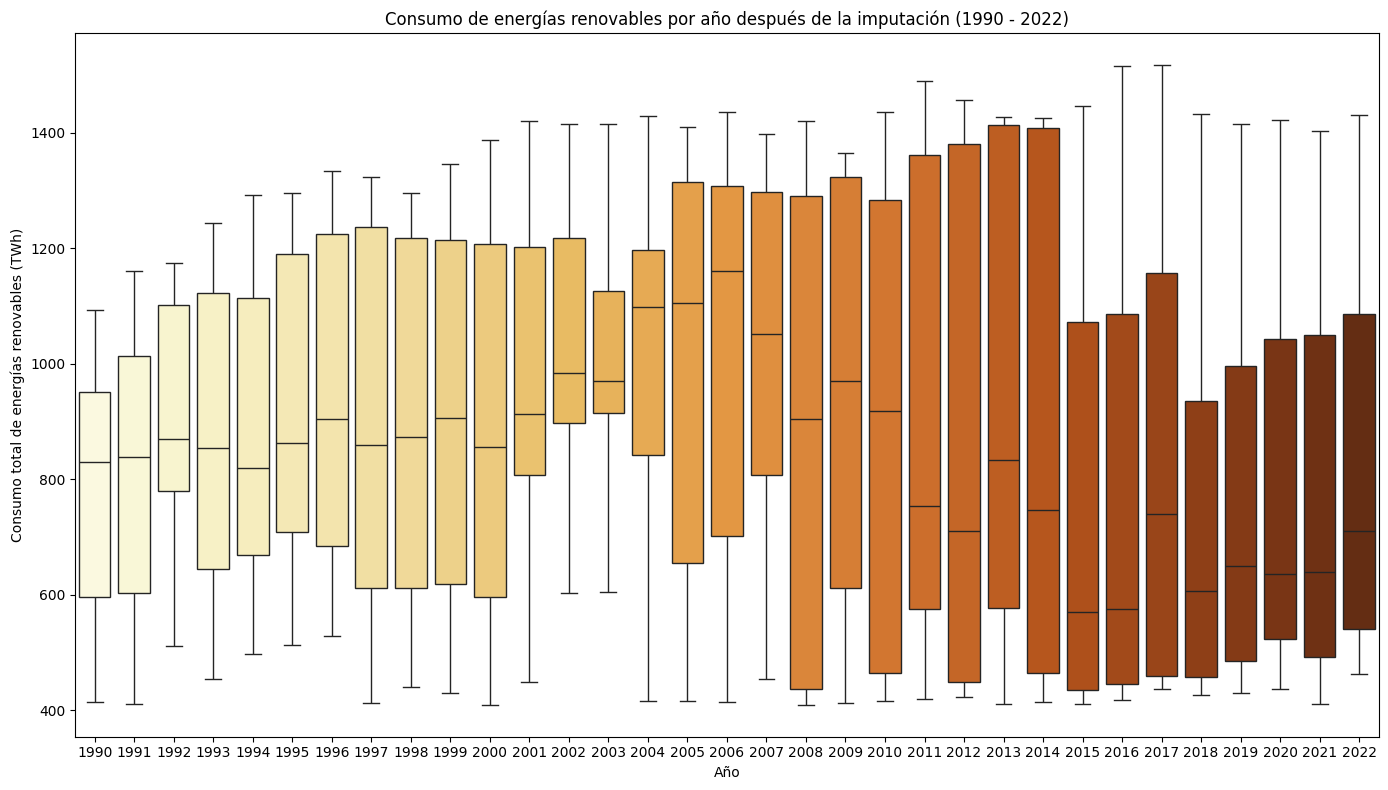

In [634]:
# 1. Eliminar valores atípicos utilizando el método del IQR
Q1 = df_top10['ren_energy'].quantile(0.25)
Q3 = df_top10['ren_energy'].quantile(0.75)
IQR = Q3 - Q1

# Definir el rango para detectar outliers
lower_bound = Q1 - 0.25 * IQR
upper_bound = Q3 + 0.25 * IQR

# Filtrar datos dentro del rango intercuartílico (eliminar outliers)
df_no_outliers = df_filtered_range[(df_filtered_range['ren_energy'] >= lower_bound) & 
                                   (df_filtered_range['ren_energy'] <= upper_bound)]

# 2. Imputación por interpolación lineal para valores faltantes
df_no_outliers[ren_energy_columns] = df_no_outliers[ren_energy_columns].interpolate(method='linear')

plt.figure(figsize=(14, 8))
sns.boxplot(data=df_no_outliers, x='year', y='ren_energy', palette='YlOrBr')

plt.title('Consumo de energías renovables por año después de la imputación (1990 - 2022)')
plt.xlabel('Año')
plt.ylabel('Consumo total de energías renovables (TWh)')

plt.tight_layout()
plt.show()

La gráfica muestra la **distribución del consumo total de energías renovables por año** después de haber realizado la **imputación de valores faltantes** y la **eliminación de outliers** usando el método del **rango intercuartílico (IQR)**.

A pesar de la eliminación de outliers, los que permanecen en la gráfica se deben a que algunos países tienen consumos excepcionalmente altos en energías renovables. El método IQR no los eliminó porque, aunque son altos, no exceden el rango de corte definido para ser eliminados como outliers extremos. Estos valores pueden reflejar políticas energéticas exitosas o inversiones significativas en energías renovables, y es importante analizarlos más a fondo en lugar de descartarlos como anomalías.

Aunque la imputación lineal ha rellenado los valores faltantes y se han eliminado muchos outliers, todavía hay países con consumos fuera del rango típico que merecen una atención especial. Estos valores no son errores, sino reflejos de comportamientos o capacidades energéticas excepcionales. El análisis de estos outliers puede ofrecer información valiosa sobre los líderes en energías renovables y las políticas que han impulsado su crecimiento.

## **Consumo de Energias Renovables y No Renovables**

### **Consumo de diferentes fuentes de Energía**

Esto tiene como objetivo visualizar la evolución temporal del consumo de energías renovables y no renovables de manera clara y diferenciada. La decisión de crear dos gráficos en una sola salida permite comparar fácilmente cómo han evolucionado estas dos categorías de energía entre los años 1990 y 2022, facilitando el análisis comparativo entre los dos tipos de fuentes energéticas.

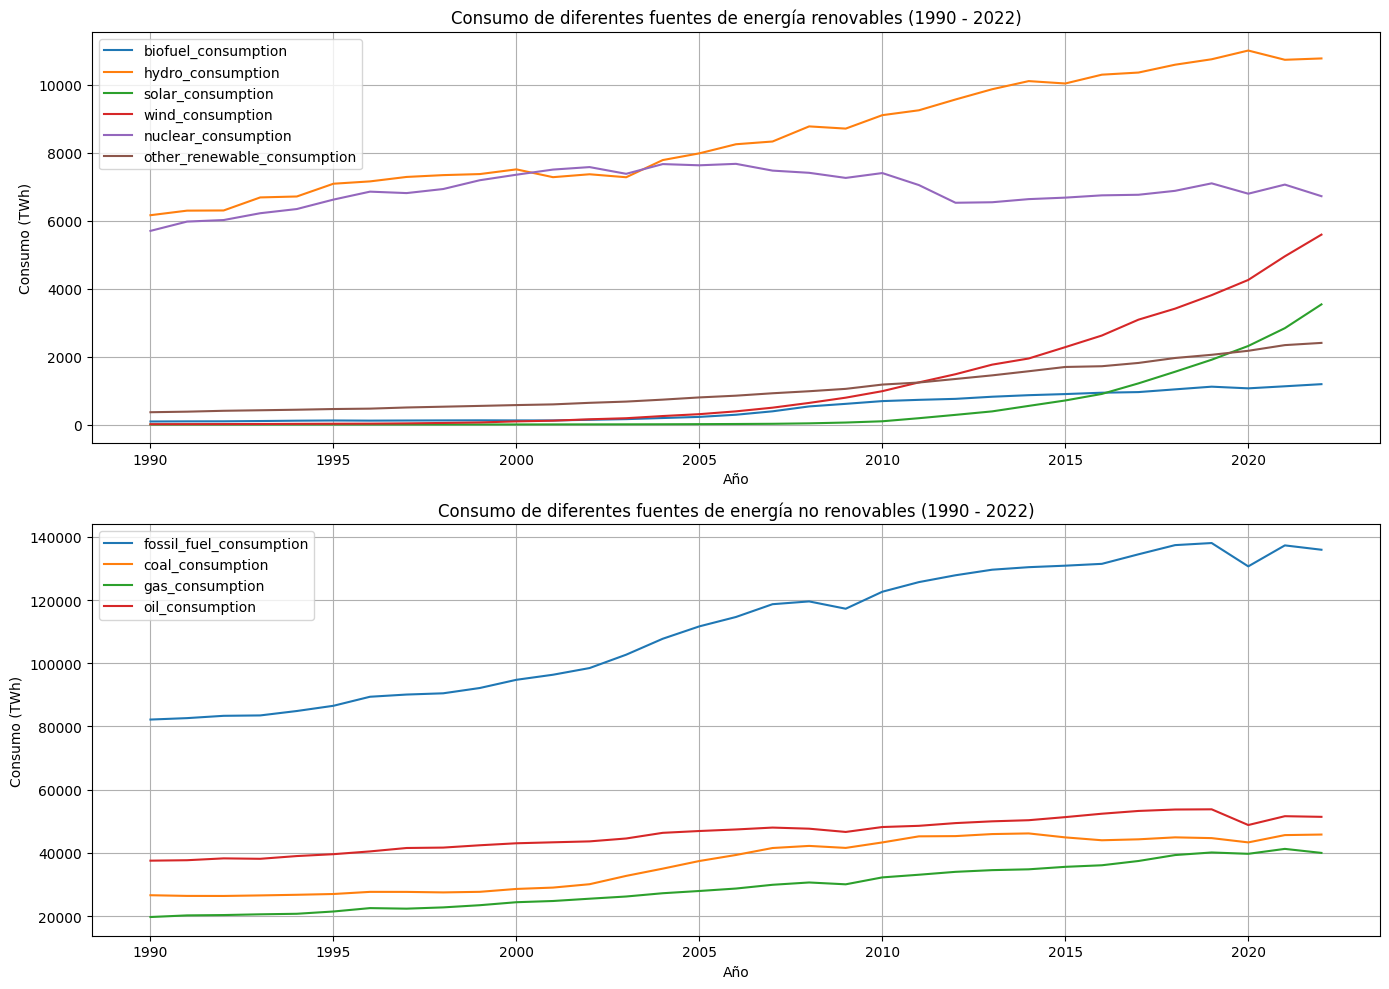

In [635]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1) 
df_filtered_plot = df_filtered_range[['year'] + ren_energy_columns].groupby('year').sum().reset_index()

for energy in ren_energy_columns:
    plt.plot(df_filtered_plot['year'], df_filtered_plot[energy], label=energy)

plt.title('Consumo de diferentes fuentes de energía renovables (1990 - 2022)')
plt.xlabel('Año')
plt.ylabel('Consumo (TWh)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)  
df_filtered_plot_nonren = df_filtered_range[['year'] + nonren_energy_columns].groupby('year').sum().reset_index()

for energy in nonren_energy_columns:
    plt.plot(df_filtered_plot_nonren['year'], df_filtered_plot_nonren[energy], label=energy)

plt.title('Consumo de diferentes fuentes de energía no renovables (1990 - 2022)')
plt.xlabel('Año')
plt.ylabel('Consumo (TWh)')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

Esta gráfica muestra dos subgráficas, una para las **energías renovables** y otra para las **energías no renovables**, permitiendo observar las tendencias de consumo de diferentes fuentes energéticas entre 1990 y 2022.

#### **Gráfica de energías renovables**:
   - **Hidroeléctrica**: Es la fuente de energía renovable más utilizada a lo largo de todo el período. Aunque su crecimiento es estable, ha habido una ligera desaceleración a partir de 2010.
   - **Nuclear**: También representa una gran parte del consumo de energías renovables, pero ha mostrado una tendencia **a la baja** desde aproximadamente el año 2005.
   - **Solar, eólica y biofuel**: Estas energías han tenido un crecimiento exponencial, especialmente a partir de 2010. La **solar** y la **eólica** muestran un aumento muy marcado, lo que refleja un fuerte avance tecnológico y políticas favorables en las últimas décadas.
   - **Otras energías renovables**: Presentan un crecimiento más modesto, pero aún relevante.

En resumen, la gráfica refleja el auge de las energías renovables **solar y eólica**, con una ralentización en las energías nucleares e hidroeléctricas. Esto sugiere un cambio hacia fuentes más modernas de energía renovable.

#### **Gráfica de energías no renovables**:
   - **Fósiles**: El consumo de **combustibles fósiles** sigue siendo extremadamente alto, y aunque muestra un crecimiento constante, parece haberse estabilizado o incluso comenzado a **disminuir levemente** después de 2010. Esto podría ser un indicio de la transición energética hacia fuentes más limpias.
   - **Carbón, gas y petróleo**: Estas tres fuentes han mostrado un crecimiento moderado hasta el año 2010, después del cual se observa una cierta estabilización o leve descenso, especialmente en el caso del **carbón**. Sin embargo, el **gas natural** sigue teniendo un consumo considerable.

En resumen, aunque el consumo de **energías no renovables** sigue siendo alto, se observa una ligera estabilización o disminución en los últimos años. Esto puede estar relacionado con políticas de descarbonización y el aumento de las energías renovables.


Las energías **renovables** (particularmente la **solar** y **eólica**) han crecido de manera significativa, mientras que las fuentes tradicionales de energía renovable (como la **hidroeléctrica** y la **nuclear**) muestran una tendencia más estable o a la baja.
Por otro lado, aunque las **energías no renovables** siguen dominando el consumo energético global, el gráfico sugiere una posible transición hacia fuentes más limpias, reflejada en la estabilización o leve disminución de su consumo en la última década.

Esto indica un cambio progresivo hacia una matriz energética más sostenible, con las energías renovables ganando terreno frente a las no renovables.

### **Consumo Total de ambas fuentes de Energía**

Esto tiene como objetivo visualizar las sumas anuales del consumo total de energías renovables y no renovables a través de gráficos de barras con etiquetas de valores encima de cada barra. La decisión de representar estos datos de esta manera busca proporcionar una visualización clara y directa que permita observar las diferencias y la evolución en el tiempo entre ambos tipos de energía, facilitando la interpretación del crecimiento o decrecimiento en el consumo.

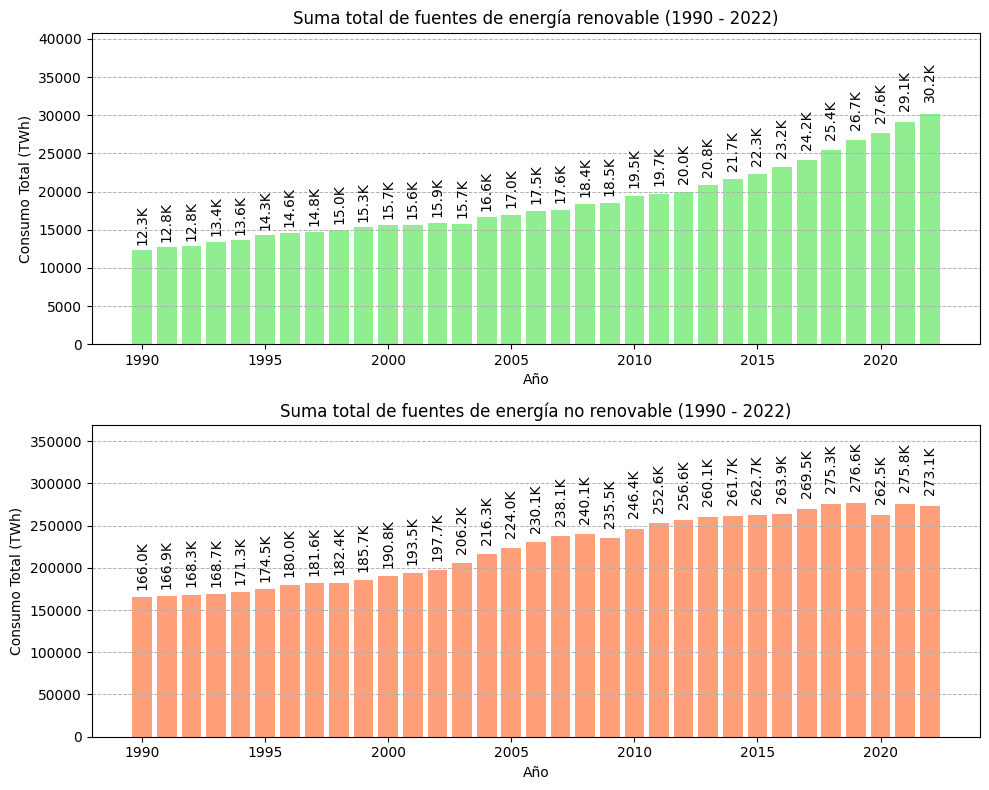

In [636]:
df_total_energy_per_year = df_filtered_range.groupby('year')[['ren_energy', 'nonren_energy']].sum().reset_index()
plt.figure(figsize=(10, 8))

def plot_bars(ax, data, color, title, y_label):
    bars = ax.bar(data['year'], data['value'], color=color, width=0.8)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.05 * yval, f'{round(yval/1000, 1)}K', ha='center', va='bottom', rotation=90)
    ax.set_title(title)
    ax.set_xlabel('Año')
    ax.set_ylabel(y_label)
    ax.grid(axis='y', linestyle='--', linewidth=0.7)
    ax.set_ylim(0, yval + yval * 0.35)

plt.subplot(2, 1, 1)
plot_bars(plt.gca(), df_total_energy_per_year.rename(columns={'ren_energy': 'value'}), '#90EE90', 'Suma total de fuentes de energía renovable (1990 - 2022)', 'Consumo Total (TWh)')

plt.subplot(2, 1, 2)
plot_bars(plt.gca(), df_total_energy_per_year.rename(columns={'nonren_energy': 'value'}), '#FFA07A', 'Suma total de fuentes de energía no renovable (1990 - 2022)', 'Consumo Total (TWh)')

plt.tight_layout()

plt.show()

Esta gráfica muestra dos subgráficas que comparan la **suma total de fuentes de energía renovable** y **no renovable** en el período entre 1990 y 2022. Las barras de cada gráfico incluyen etiquetas con los valores anuales en teravatios-hora (TWh) para una interpretación numérica directa.

- La gráfica refleja dos tendencias distintas: mientras que las **energías renovables** muestran un crecimiento acelerado, las **energías no renovables** han mantenido un alto nivel de consumo con una leve estabilización en los últimos años.
- Esto indica un **progreso hacia la transición energética**, donde las fuentes renovables están ganando terreno, aunque las fuentes no renovables siguen dominando el consumo energético mundial.
- El crecimiento reciente de las energías renovables sugiere que los esfuerzos por reducir la dependencia de los combustibles fósiles están comenzando a tener un impacto notable, aunque aún se requiere un cambio más drástico para desplazar completamente a las fuentes no renovables.

Si bien el uso de energías renovables ha aumentado significativamente, la gráfica muestra que todavía existe una **gran brecha** entre el consumo de fuentes renovables y no renovables, lo que subraya la magnitud del desafío que enfrenta el mundo en términos de transición energética.

Representar los datos mediante gráficas de pastel tiene como objetivo proporcionar una visión clara y sencilla de la distribución porcentual del consumo de diferentes fuentes de energía renovable y no renovable. Este tipo de gráfico permite visualizar de forma directa qué fuentes de energía dominan el consumo total en el período de 1990 a 2022, facilitando una rápida comparación entre las diferentes categorías de energía.

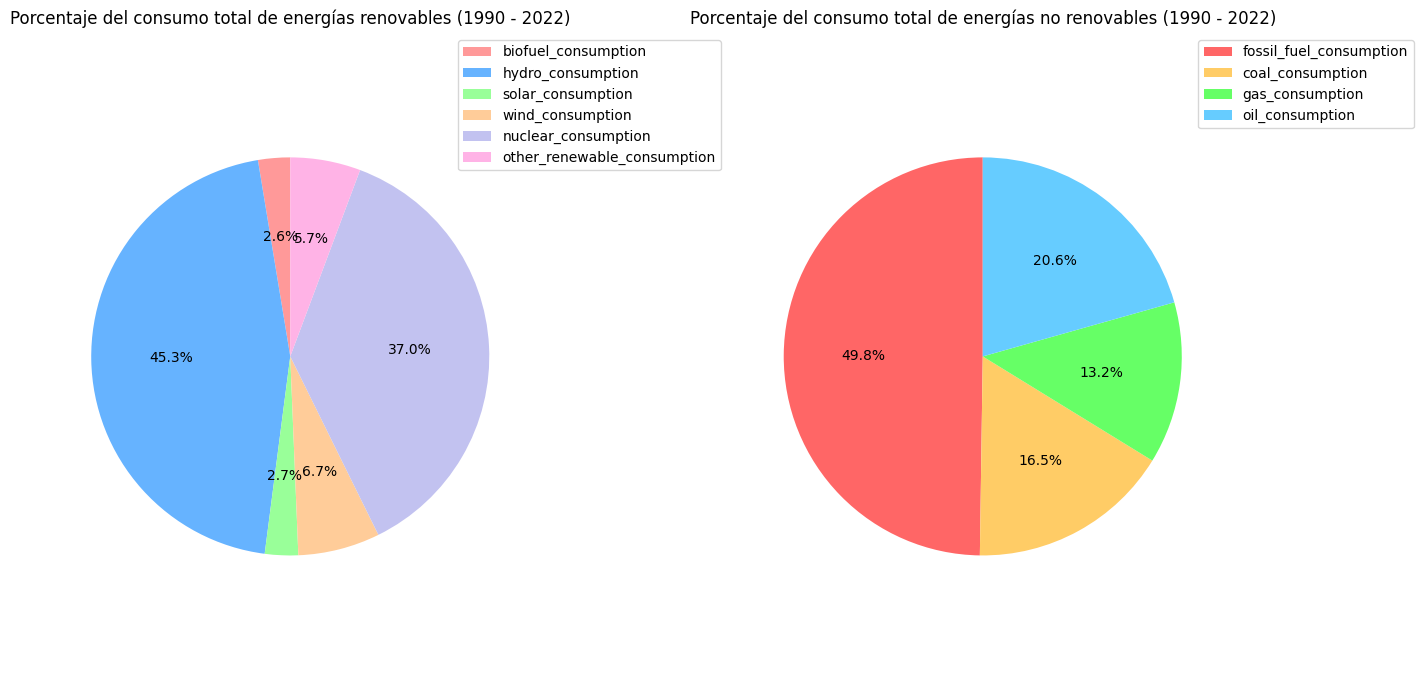

In [637]:
df_renewable_total = df_filtered_range[ren_energy_columns].sum()
df_nonrenewable_total = df_filtered_range[nonren_energy_columns].sum()

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.pie(df_renewable_total, autopct='%1.1f%%', startangle=90, 
        colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6'])
plt.title('Porcentaje del consumo total de energías renovables (1990 - 2022)')
plt.axis('equal')  
plt.legend(ren_energy_columns, loc="best", bbox_to_anchor=(1, 0, 0.5, 1))  

plt.subplot(1, 2, 2)
plt.pie(df_nonrenewable_total, autopct='%1.1f%%', startangle=90, 
        colors=['#ff6666', '#ffcc66', '#66ff66', '#66ccff'])
plt.title('Porcentaje del consumo total de energías no renovables (1990 - 2022)')
plt.axis('equal')  
plt.legend(nonren_energy_columns, loc="best", bbox_to_anchor=(1, 0, 0.5, 1)) 

plt.tight_layout()

plt.show()

Estas gráficas proporcionan una visión clara de cómo se distribuye el consumo de energía entre las distintas fuentes, tanto renovables como no renovables. Se puede observar que, aunque las energías renovables están ganando relevancia, las fuentes no renovables (especialmente los combustibles fósiles) aún constituyen una parte importante de la producción energética global. Las energías hidroeléctrica y nuclear dominan dentro de las renovables, mientras que los combustibles fósiles siguen siendo la principal fuente de energía no renovable.

## **Consumo de Energía por paises**

### **Consumo de Energía en el mundo**

El uso de un **mapa coroplético** para representar el **consumo total de energías renovables por país** tiene como objetivo proporcionar una **visualización geoespacial** que permite identificar visualmente qué regiones del mundo están contribuyendo más al consumo de energías limpias. Esta decisión se tomó para hacer evidente la **distribución desigual** de la adopción de energías renovables, donde algunos países son líderes y otros aún tienen un consumo bajo.

In [638]:
df_renewable_consumption = df_filtered_range.groupby('country')[ren_energy_columns].sum().reset_index()

df_renewable_consumption['total_renewable'] = df_renewable_consumption[ren_energy_columns].sum(axis=1)

fig = px.choropleth(df_renewable_consumption, 
                    locations="country", 
                    locationmode="country names",
                    color="total_renewable", 
                    hover_name="country", 
                    title="Consumo total de energías renovables por país (1990 - 2022)",
                    projection="natural earth",
                    color_continuous_scale=px.colors.sequential.YlGnBu,  
                    range_color=(0, 150000),  
                    labels={'total_renewable':'Consumo Total de Energía (TWh)'})

fig.update_geos(showcoastlines=True, coastlinecolor="Black",
                showland=True, landcolor="white",
                showocean=True, oceancolor="LightBlue",
                showlakes=True, lakecolor="LightBlue",
                showrivers=True, rivercolor="LightBlue",
                showcountries=True, countrycolor="black")

fig.show()


   - Los países con los colores más oscuros, como **Estados Unidos** y **China**, son los principales consumidores de energías renovables, reflejando su gran tamaño, capacidad industrial, y políticas enfocadas a la transición energética.
   - **Canadá**, también con un color oscuro, es otro actor importante en el consumo de energías renovables, gracias a su vasta capacidad hidroeléctrica.

   - Países en **América Latina**, **África**, y partes de **Asia** muestran colores más claros, lo que indica un menor consumo de energías renovables. Esto puede estar relacionado con limitaciones económicas, tecnológicas o de infraestructura que dificultan la adopción de estas fuentes de energía.
   - **Europa** aparece en tonos más claros en general, lo que podría reflejar que, aunque muchos países europeos están avanzando en la adopción de energías renovables, su tamaño y demanda energética total es menor comparado con países como China o EE. UU.

   - Este mapa resalta las **disparidades globales** en el consumo de energías renovables. Si bien algunos países están avanzando rápidamente hacia una mayor adopción de fuentes limpias, muchos otros todavía dependen de fuentes no renovables o no han logrado desarrollar suficiente capacidad renovable.
   - La representación geoespacial es una herramienta poderosa para **visualizar las diferencias regionales** y ayuda a identificar áreas donde es necesario un mayor enfoque en políticas de energía limpia para promover una adopción más equitativa a nivel mundial.

En resumen, esta gráfica facilita la **interpretación global** del consumo de energías renovables, destacando a los principales actores y mostrando las regiones que podrían beneficiarse de mayores inversiones en infraestructura energética sostenible.

### **Representación de los 10 países que mas consumen energía renovable**

Para representar a los 10 países con mayor consumo de energías renovables permite una comparación clara y visual de los valores de consumo acumulado entre los países. Al ordenar las barras de mayor a menor, se facilita la interpretación inmediata de quiénes son los principales consumidores de energías renovables, destacando las diferencias entre cada país.

Este tipo de gráfico es eficaz para mostrar datos ordenados y para resaltar el valor absoluto del consumo en cada país, lo que lo hace perfecto para observar tendencias a largo plazo como en este caso, que abarca el consumo desde 1990 hasta 2022.

In [639]:
fig = px.bar(df_top10_renewable, 
             x='total_renewable', 
             y='country', 
             text='total_renewable', 
             title='Top 10 países con mayor consumo de energías renovables per cápita (1990 - 2022)',
             labels={'total_renewable': 'Consumo Total de Energía (TWh)', 'country': 'País'},
             orientation='h',
             color='total_renewable', 
             color_continuous_scale='YlOrBr')

fig.update_traces(texttemplate='%{text:.3s}', textposition='outside')
fig.update_layout(xaxis_title='Consumo Total de Energía (TWh)', 
                  yaxis_title='País',
                  showlegend=False)

fig.show()

Este gráfico muestra claramente que, aunque Estados Unidos y China dominan el consumo de energías renovables a nivel mundial, otros países como Francia, Canadá, y Brasil también desempeñan un papel importante en la transición hacia fuentes de energía más limpias. La distribución de los colores refuerza visualmente estas diferencias y facilita una interpretación clara del consumo total de cada país.

En resumen, esta visualización destaca la distribución desigual del consumo de energías renovables entre los países, lo que refleja tanto el tamaño económico de cada nación como sus políticas energéticas específicas, y permite una fácil identificación de los líderes globales en la adopción de energías limpias.

## **Evolución del porcentaje de energías renovables**

### **Promedio Porcentual - Energias Renovables vs No Renovables**

El porcentaje de consumo de energías renovables frente a no renovables a lo largo del tiempo (1990 - 2022) tiene el propósito de visualizar la evolución relativa de las energías renovables en comparación con el consumo total. Este enfoque permite observar cómo ha crecido (o disminuido) el peso de las energías renovables en el consumo energético global, lo que es crucial para medir el progreso hacia una transición energética más sostenible.

El gráfico de línea es ideal para este tipo de análisis temporal, ya que muestra claramente las tendencias a lo largo del tiempo y permite identificar momentos clave de crecimiento o estancamiento en la adopción de energías renovables.

In [640]:
df_annual_consumption = df_filtered_range.groupby('year')[ren_energy_columns + nonren_energy_columns].sum().reset_index()

df_annual_consumption['total_renewable'] = df_annual_consumption[ren_energy_columns].sum(axis=1)
df_annual_consumption['total_nonrenewable'] = df_annual_consumption[nonren_energy_columns].sum(axis=1)

df_annual_consumption['percentage_renewable'] = (df_annual_consumption['total_renewable'] / 
                                                 (df_annual_consumption['total_renewable'] + df_annual_consumption['total_nonrenewable'])) * 100

fig = px.line(df_annual_consumption, 
              x='year', 
              y='percentage_renewable', 
              title='Porcentaje de consumo de energías renovables vs no renovables (1990 - 2022)',
              labels={'percentage_renewable': 'Porcentaje de Energías Renovables (%)', 'year': 'Año'},
              markers=True)

fig.update_traces(texttemplate='%{y:.1f}%', textposition="top right")

fig.show()

Se calcula el consumo total anual tanto de energías renovables como de no renovables. Luego, se utiliza esta información para calcular el porcentaje que representa el consumo de energías renovables sobre el consumo total (renovable + no renovable) cada año.

El incremento más marcado ocurre en los últimos cinco años, lo que indica un progreso considerable en la adopción de energías limpias a nivel global. Sin embargo, aunque el crecimiento es notable, el porcentaje sigue siendo relativamente bajo en comparación con el total de consumo, lo que señala la necesidad de mayores esfuerzos en la transición hacia un consumo más sostenible.

Este gráfico de línea muestra claramente cómo el porcentaje de energías renovables ha fluctuado a lo largo de los años, con un estancamiento en la década de 2000 y un crecimiento acelerado en la última década. Esto es un reflejo de cómo las políticas energéticas, los avances tecnológicos, y las demandas de sostenibilidad están impulsando el incremento en la adopción de energías renovables.

## **Consumo de Energías Renovables por medio de un Mapa de Calor**

Con esto ofrece una visión comparativa de qué fuentes de energía predominan en distintos países, así como identificar el volumen relativo de consumo entre las diferentes fuentes y países. Este tipo de gráfico es ideal para visualizar matrices de datos donde cada celda contiene un valor numérico, ya que permite observar de manera intuitiva los valores más altos y más bajos a través de una escala de color.

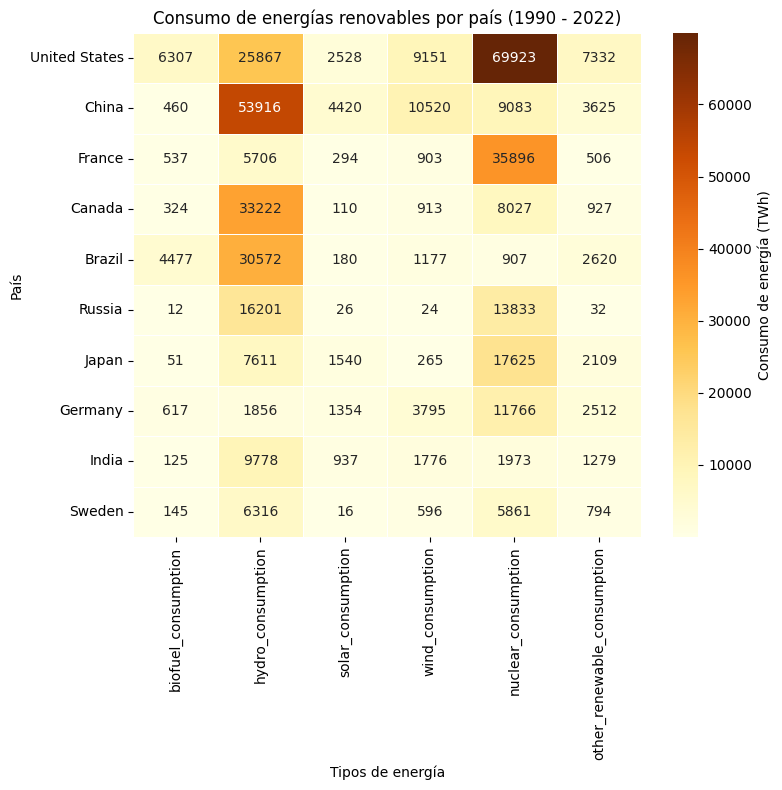

In [641]:
plt.figure(figsize=(8, 8))
ax = sns.heatmap(df_top10_renewable.set_index('country')[ren_energy_columns], 
                 annot=True, fmt='.0f', cmap='YlOrBr', linewidths=.5, cbar_kws={'label': 'Consumo de energía (TWh)'})

plt.title('Consumo de energías renovables por país (1990 - 2022)')
plt.xlabel('Tipos de energía')
plt.ylabel('País')

plt.tight_layout()
plt.show()

Permite una rápida comparación entre los países en cuanto a su consumo de distintos tipos de energías renovables. Ayuda a identificar patrones regionales y resalta la heterogeneidad en el uso de fuentes renovables, desde países con una fuerte dependencia en hidroenergía, como Brasil y China, hasta aquellos con un predominio nuclear, como Estados Unidos y Francia.

## Conclusiones

El consumo de energías renovables ha mostrado un crecimiento sostenido desde 1990, especialmente en fuentes como la energía solar, eólica e hidroeléctrica. Este aumento refleja los esfuerzos de muchos países por diversificar sus matrices energéticas y reducir su dependencia de combustibles fósiles, en respuesta tanto a factores económicos como a las presiones derivadas del cambio climático.

A pesar del crecimiento global, existe una disparidad significativa en el uso de fuentes renovables entre los diferentes países. Mientras que algunos países como Estados Unidos, China, y Brasil lideran el consumo total, otros dependen principalmente de una o dos fuentes específicas, como la energía nuclear en Francia y la hidroenergía en Canadá y Suecia. Aunque el consumo de energías renovables ha crecido, la proporción del consumo renovable frente al consumo no renovable todavía sigue siendo baja. 

El análisis muestra que aunque se han hecho avances importantes en la adopción de energías renovables a nivel mundial, la dependencia de los combustibles fósiles sigue siendo alta. Para lograr los objetivos climáticos internacionales, será crucial acelerar la transición energética, incrementar la inversión en tecnologías limpias y asegurar una distribución más equitativa de las fuentes renovables a nivel global.